In [1]:

def distribute_samples(m, t):
    """
    distribute m samples to t steps
    strategy: distribute samples as evenly as possible, and then distribute the remaining samples from the beginning
    """
    base = m // t
    remainder = m % t
    
    distribution = [base for _ in range(t)]
    
    for i in range(remainder):
        distribution[i] += 1
    
    return distribution

def remove_boxed(s):
    if "\\fbox{" in s:
        left = "\\fbox{"
        assert s[: len(left)] == left
        assert s[-1] == "}"
        return s[len(left) : -1]

    if "\\boxed " in s:
        left = "\\boxed "
        assert s[: len(left)] == left
        return s[len(left) :]

    left = "\\boxed{"

    return s[len(left) : -1]


def last_boxed_only_string(string):
    idx = string.rfind("\\boxed")
    if "\\boxed " in string:
        return "\\boxed " + string.split("\\boxed ")[-1].split("$")[0]
    if idx < 0:
        idx = string.rfind("\\fbox")
        if idx < 0:
            return None

    i = idx
    right_brace_idx = None
    num_left_braces_open = 0
    while i < len(string):
        if string[i] == "{":
            num_left_braces_open += 1
        if string[i] == "}":
            num_left_braces_open -= 1
            if num_left_braces_open == 0:
                right_brace_idx = i
                break
        i += 1

    if right_brace_idx is None:
        retval = None
    else:
        retval = string[idx : right_brace_idx + 1]

    return retval



In [2]:

import os
import re
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import prime_math
import random

def calculate_bon_at_k(
    base_folder, 
    model_prefix, 
    base_model, 
    task_name, 
    max_t=8, 
    max_k=64, 
    reward_score="prm",
    reward_model="QwenReward72B",
):
    """
    Calculate best of n metric based on reward model scores
    
    Args:
    - base_folder: Path to folder containing evaluation files
    - model_prefix: Model name prefix
    - base_model: Base model name (as step 0)
    - task_name: Task name
    - max_t: Maximum number of ckpts
    - max_k: Maximum number of samples
    - reward_score: Score type to use ("prm" or "orm")
    - reward_model: Reward model to use
    
    Returns:
    - bon_at_k: Best of n metric dict with keys (t, k)
    """
    # Get model folder paths
    model_folders = []
    # Use automatic search logic
    for item in os.listdir(base_folder):
        item_path = os.path.join(base_folder, item)
        if os.path.isdir(item_path) and item.startswith(model_prefix):
            # Try to extract step number
            step_match = re.search(r'(?:step|checkpoint)_?(\d+)', item)
            if step_match:
                step = int(step_match.group(1))
                model_folders.append((step, item_path))
    
    # Add base model as step 0
    base_model_path = os.path.join(base_folder, base_model)
    if os.path.isdir(base_model_path):
        model_folders.append((0, base_model_path))
    
    # Sort by step
    model_folders = sorted(model_folders, key=lambda x: x[0])
    
    if not model_folders:
        print(f"No matching model folders found in {base_folder}")
        return {}
    
    # Store evaluation results for each problem at different steps
    problem_evaluations = defaultdict(lambda: defaultdict(list))
    # Record standard answers for all problems
    standard_answers = {}
    # Record all encountered problem indices
    all_problem_indices = set()
    
    # Process each model folder
    for step, folder_path in model_folders:
        # Look for prm_scored.json file with task_name
        result_file = os.path.join(folder_path, f"{reward_model}_{task_name}_prm_scored.json")
        
        if not os.path.exists(result_file):
            print(f"Warning: Result file for task {task_name} not found in {folder_path}")
            continue
        
        try:
            with open(result_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Process results for each problem
            for problem in data:
                doc_id = problem.get("doc_id", -1)
                
                if doc_id >= 0:
                    all_problem_indices.add(doc_id)
                    
                    # Save standard answer
                    if doc_id not in standard_answers:
                        standard_answers[doc_id] = problem.get("standard_answer", "")
                    
                    # Get all responses and their scores
                    responses = []
                    for resp in problem.get("responses", []):
                        # Choose score based on reward_score parameter
                        if reward_score == "prm":
                            score = resp.get("prm_score", 0)
                        else:  # Use orm_score
                            score = resp.get("orm_score", 0)
                        
                        response_text = resp.get("response", "")
                        responses.append((score, response_text))
                    
                    # Save all responses to problem evaluation results
                    problem_evaluations[doc_id][step] = responses
        
        except (json.JSONDecodeError, FileNotFoundError) as e:
            print(f"Error: Cannot read or parse file {result_file}: {e}")
    
    # Get all steps and sort
    all_steps = sorted(list(set().union(*[d.keys() for d in problem_evaluations.values()])))
    
    # Build step sequence in reverse order
    ordered_steps = []
    for s in sorted(all_steps, reverse=True):
        ordered_steps.append(s)
    
    # Print step sequence for debugging
    print(f"Step sequence: {ordered_steps[:max_t]}")

    # Shuffle responses for each problem at each step before calculation
    for doc_id in all_problem_indices:
        for step in all_steps:
            if step in problem_evaluations.get(doc_id, {}):
                # Shuffle all responses for this problem at this step
                random.shuffle(problem_evaluations[doc_id][step])
        
    # Calculate best of n for each t and m combination
    bon_at_k = {}
    total_problems = len(all_problem_indices)

    for t in range(1, min(len(ordered_steps), max_t) + 1):
        considered_steps = ordered_steps[:t]
        
        for m in range(1, max_k + 1):
            correct_count = 0

            # Calculate how to distribute m samples among t models
            samples_per_step = distribute_samples(m, t)
            
            for doc_id in all_problem_indices:
                # Get standard answer
                standard_answer = standard_answers.get(doc_id, "")
                if not standard_answer:
                    continue
                
                # Collect all responses and their scores from considered steps
                all_responses = []
                
                # Get responses from each step based on sample distribution
                for s_idx, s in enumerate(considered_steps):
                    responses = problem_evaluations.get(doc_id, {}).get(s, [])
                    
                    # Only get the allocated number of samples for current step
                    samples_for_step = samples_per_step[s_idx]
                    
                    # Ensure not exceeding k and actual available responses
                    samples_to_use = min(samples_for_step, len(responses))
                    
                    # Add current step's responses to total response list
                    all_responses.extend(responses[:samples_to_use])
                
                # If no responses found, continue to next problem
                if not all_responses:
                    continue

                # Filter out responses without boxed answers
                filtered_responses = []
                for score, resp_text in all_responses:
                    boxed_answer = last_boxed_only_string(resp_text)

                    if boxed_answer is not None:
                        removed_boxed_answer = remove_boxed(last_boxed_only_string(resp_text))
                        # remove bad cases from the answer
                        if "your" not in removed_boxed_answer.lower():
                            filtered_responses.append((score, removed_boxed_answer))
                
                # If all responses have no boxed answers, continue to next problem
                if not filtered_responses:
                    continue
                
                # Sort by score and select highest scoring response (Best of N logic)
                filtered_responses.sort(key=lambda x: x[0], reverse=True)
                best_response = filtered_responses[0]
                best_score, response_text = best_response

                # Check if response is correct
                is_correct, _, _ = prime_math.compute_score(response_text, standard_answer)
                
                if is_correct:
                    correct_count += 1
            
            # Save result for (t, m) combination
            bon_score = (correct_count / total_problems) * 100 if total_problems else 0
            bon_at_k[(t, m)] = bon_score
            
    return bon_at_k

In [3]:
def calculate_bon_at_k_multi_runs(
    base_folder, 
    model_prefix, 
    base_model, 
    task_name, 
    max_t=8, 
    max_k=64, 
    reward_score="prm",
    reward_model="QwenReward72B",
    runs=50,
):
    """
    Run calculate_bon_at_k multiple times and calculate average
    
    Args:
    - runs: Number of runs
    - Other parameters same as calculate_bon_at_k
    
    Returns:
    - Average results from multiple runs
    """
    # Store results from all runs
    all_results = {}
    
    # Run calculate_bon_at_k multiple times
    for run in range(runs):
        print(f"Run {run+1}/{runs}...")
        
        # Execute single run calculation
        single_run_results = calculate_bon_at_k(
            base_folder=base_folder,
            model_prefix=model_prefix,
            base_model=base_model,
            task_name=task_name,
            max_t=max_t,
            max_k=max_k,
            reward_score=reward_score,
            reward_model=reward_model,
        )
        
        # Collect results
        for key, value in single_run_results.items():
            if key not in all_results:
                all_results[key] = []
            all_results[key].append(value)
        
    
    # Calculate average values
    average_results = {}
    
    for key, values in all_results.items():
        average_results[key] = sum(values) / len(values)
    
    
    # Return average results
    return average_results

In [6]:

base_folder = "../sampling_64_responses"
model_prefix = "UWNSL__Qwen2.5-7B-deepscaler_4k_step_"
base_model = "Qwen__Qwen2.5-7B"
task_name = "AIME"

bon_at_k_avg_results = calculate_bon_at_k_multi_runs(
    base_folder=base_folder,
    model_prefix=model_prefix,
    base_model=base_model,
    task_name=task_name,
    max_t=8,
    max_k=64,
    reward_score="prm",
    reward_model="QwenReward72B",
    runs=30
)

Run 1/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]


/home/nsl/anaconda3/envs/lm_eval/lib/python3.10/site-packages/sympy/parsing/latex/_parse_latex_antlr.py:23: UserWarning: antlr4.error.ErrorListener module is not installed
  ErrorListener = import_module('antlr4.error.ErrorListener',


Run 2/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 3/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 4/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 5/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 6/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 7/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 8/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 9/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 10/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 11/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 12/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 13/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 14/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 15/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 16/50...
Step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 17/50...
Step 

In [4]:
import json

output_file_path = 'exp_results/bon_at_k_results_AIME_Qwen2.5-7B_RL.json'
converted_dict = {f"{t}_{m}": value for (t, m), value in bon_at_k_avg_results.items()}
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(converted_dict, f, indent=2)

print(f"Dictionary Saved in: {output_file_path}")


NameError: name 'bon_at_k_avg_results' is not defined

Chart saved as: exp_results/bon_at_k_results_AIME_Qwen2.5-7B_RL_plot.png


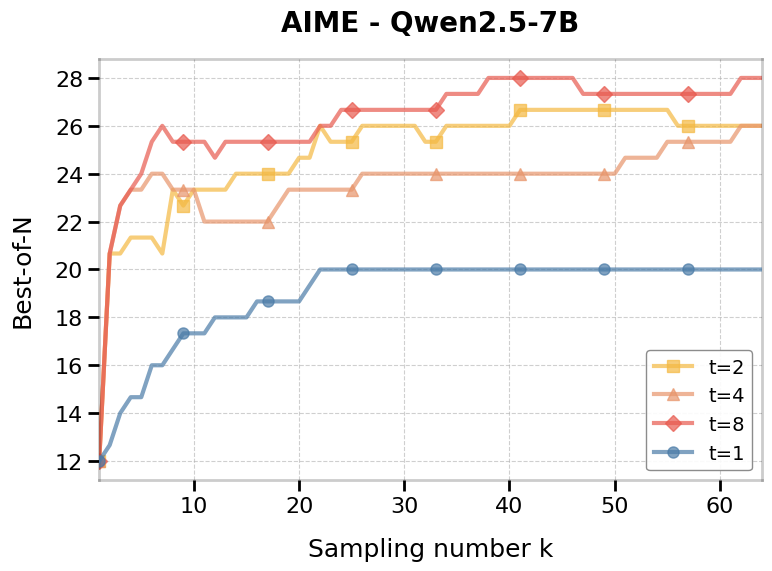

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_bon_at_k(filename, title=None, figsize=(8, 6)):
    """
    Plot Pass@k chart for a single data file
    
    Parameters:
    - filename: path to data file
    - title: chart title, auto-generated if None
    - figsize: chart dimensions
    """
    
    # Set clear and readable font configurations
    plt.rcParams.update({
        'font.size': 16,           
        'axes.titlesize': 20,      
        'axes.labelsize': 18,      
        'xtick.labelsize': 16,     
        'ytick.labelsize': 16,     
        'legend.fontsize': 14      
    })
    
    # Color and style configurations
    temporal_colors = {
        1: '#4A7BA7',    # Cool tone - dedicated for t=1 (fresh blue)
        2: '#F4B942',    # Warm tone - bright yellow
        4: '#E8956B',    # Warm tone - coral red
        8: '#E85A4F'     # Warm tone - warm orange
    }
    
    temporal_markers = {
        1: 'o',     # Circle - dedicated for t=1
        2: 's',     # Square
        4: '^',     # Triangle
        8: 'D'      # Diamond
    }
    
    temporal_linestyles = {
        1: '-',     # Solid line
        2: '-',     # Solid line
        4: '-',     # Solid line
        8: '-'      # Solid line
    }
    
    temporal_linewidths = {
        1: 3,       # t=1 thicker
        2: 3,
        4: 3,
        8: 3
    }
    
    temporal_markersizes = {
        1: 8,       # t=1 slightly larger
        2: 8,
        4: 8,
        8: 8
    }
    
    temporal_values = [1, 2, 4, 8]
    
    # Create chart
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    try:
        # Load data
        with open(filename, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
        
        # Restore tuple keys
        parsed_results = {tuple(map(int, key.split('_'))): value for key, value in raw_data.items()}
        
        # Get all available m values
        all_sampling_numbers = sorted(list(set(m for _, m in parsed_results.keys())))
        
        # First plot t=2,4,8 lines (background layer)
        for t in [2, 4, 8]:
            temporal_pass_rates = []
            for sampling_num in all_sampling_numbers:
                current_pass_rate = parsed_results.get((t, sampling_num), 0)
                temporal_pass_rates.append(current_pass_rate)
            
            # Adjust marker density based on data point count
            marker_frequency = 8 if len(all_sampling_numbers) <= 100 else 15
            
            ax.plot(all_sampling_numbers, temporal_pass_rates, 
                    label=f't={t}',
                    color=temporal_colors[t], 
                    marker=temporal_markers[t], 
                    markersize=temporal_markersizes[t],
                    linewidth=temporal_linewidths[t],    
                    linestyle=temporal_linestyles[t],
                    markevery=marker_frequency,
                    alpha=0.7)
        
        # Finally plot t=1 line (foreground layer, most prominent)
        t = 1
        temporal_pass_rates = []
        for sampling_num in all_sampling_numbers:
            current_pass_rate = parsed_results.get((t, sampling_num), 0)
            temporal_pass_rates.append(current_pass_rate)
        
        marker_frequency = 8 if len(all_sampling_numbers) <= 100 else 15
        
        ax.plot(all_sampling_numbers, temporal_pass_rates, 
                label=f't={t}',
                color=temporal_colors[t], 
                marker=temporal_markers[t], 
                markersize=temporal_markersizes[t],
                linewidth=temporal_linewidths[t],
                linestyle=temporal_linestyles[t],
                markevery=marker_frequency,
                alpha=0.7,
                zorder=10)  # Ensure it's in the foreground
        
        # Set chart properties
        if title is None:
            # Auto-generate title from filename
            title = filename.split('/')[-1].replace('.json', '').replace('_', ' ').title()
        
        ax.set_title(title, fontsize=20, pad=20, weight='bold')
        ax.set_xlabel('Sampling number k', fontsize=18, labelpad=15)
        ax.set_ylabel('Best-of-N', fontsize=18, labelpad=15)
        
        # Set grid and axes
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlim(1, max(all_sampling_numbers))
        
        # Set borders and ticks
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_alpha(0.2)
        
        ax.tick_params(width=2, length=8, labelsize=16)
        
        # Add legend
        ax.legend(fontsize=14, frameon=True, framealpha=0.9, edgecolor='gray')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save charts
        output_png_path = filename.replace('.json', '_plot.png')
        plt.savefig(output_png_path, dpi=150, bbox_inches='tight')
        plt.savefig(output_png_path.replace('.png', '.pdf'), bbox_inches='tight')
        
        print(f"Chart saved as: {output_png_path}")
        plt.show()
        
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"Error during plotting: {e}")


if __name__ == "__main__":
    # Plot chart for specified file
    plot_bon_at_k(
        'exp_results/bon_at_k_results_AIME_Qwen2.5-7B_RL.json',
        title='AIME - Qwen2.5-7B'
    )